# Amazon Personalize: using item metadata to identify stronger similarities

The relevance of the recommendations you deliver with Amazon Personalize depends on the data available when the recommendations are generated. Amazon Personalize uses your users’ historical interactions, the attributes of your items, and your users’ metadata to learn what items are most relevant for each user. The primary data required by Amazon Personalize is user-item interactions. The interactions users have with items in your catalog, such as clicking on a product, reading an article, watching a video, or purchasing a product, are an important signal of what they have found relevant in the past. Including item and user attributes, also known as metadata, can enhance the relevance of recommendations; especially for new items that are similar to what your users have found relevant. However, structured metadata such as an item’s category, style, or genre may not always be readily available or doesn’t provide all the information that you have in your narrative descriptions. 

Now Amazon Personalize allows you to add item metadata such as product descriptions, genre of a movie, etc.. Amazon Personalize hosts, manages, and automatically processes your item metadata attributes and use it to improve the performance of your Amazon Personalize related items solutions.

This notebook will demonstrate how the new recipe `aws-similar-items` plus item metadata improves the relevance of recommendations compared to the `SIMS` recipe.

Amazon Reviews data from the Amazon Prime Pantry category are used for the interactions and items datasets.

When considering including text in your items dataset, keep the following best practices in mind.

One dataset group will be created that will include the interactions data plus item metadata this way we can train two separate models and compare their offline and online results.

In [4]:
import pandas as pd
import json
import numpy as np
from datetime import datetime
import boto3
import time
from time import sleep
from lxml import html

## Load and inspect datasets

We'll start by loading the Prime Pantry reviews dataset. You will need to fill out the form for access to the data files:

http://deepyeti.ucsd.edu/jianmo/amazon/index.html

Citation:
> Justifying recommendations using distantly-labeled reviews and fined-grained aspects  
> Jianmo Ni, Jiacheng Li, Julian McAuley  
> Empirical Methods in Natural Language Processing (EMNLP), 2019 [pdf](http://cseweb.ucsd.edu/~jmcauley/pdfs/emnlp19a.pdf)

In [2]:
data_dir = 'raw_data'

In [26]:
!mkdir $data_dir

!cd $data_dir && \
    wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Prime_Pantry.json.gz && \
    wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Prime_Pantry.json.gz

mkdir: cannot create directory ‘raw_data’: File exists
--2022-02-22 09:33:51--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Prime_Pantry.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45435146 (43M) [application/octet-stream]
Saving to: ‘Prime_Pantry.json.gz.1’

Prime_Pantry.json.g 100%[===================>]  43.33M  3.11MB/s    in 17s     

2022-02-22 09:34:08 (2.59 MB/s) - ‘Prime_Pantry.json.gz.1’ saved [45435146/45435146]

--2022-02-22 09:34:08--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Prime_Pantry.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5281662 (5.0M) [application/octet-stream]
Saving to: ‘meta_Prime_Pantry.json.gz.1’

meta_Pr

### Load and inspect reviews data

We'll start by loading the reviews dataset for the Prime Pantry products and running some commands to see what we have to work with.

In [3]:
pantry_df = pd.read_json(data_dir + '/Prime_Pantry.json.gz', lines=True, compression='infer')
pantry_df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,5,True,"12 14, 2014",A1NKJW0TNRVS7O,B0000DIWNZ,Tamara M.,Good clinging,Clings well,1418515200,NaN,NaN,NaN
1,4,True,"11 20, 2014",A2L6X37E8TFTCC,B0000DIWNZ,Amazon Customer,Fantastic buy and a good plastic wrap. Even t...,Saran could use more Plus to Cling better.,1416441600,NaN,NaN,NaN
2,4,True,"10 11, 2014",A2WPR4W6V48121,B0000DIWNZ,noname,ok,Four Stars,1412985600,NaN,NaN,NaN
3,3,False,"09 1, 2014",A27EE7X7L29UMU,B0000DIWNZ,ZapNZs,Saran Cling Plus is kind of like most of the C...,"The wrap is fantastic, but the dispensing, cut...",1409529600,4,NaN,NaN
4,4,True,"08 10, 2014",A1OWT4YZGB5GV9,B0000DIWNZ,Amy Rogers,This is my go to plastic wrap so there isn't m...,has been doing it's job for years,1407628800,NaN,NaN,NaN


In [4]:
pantry_df.shape

(471614, 12)

What can we learn from this output? There are over 471K reviews and 12 columns of data. The `asin` column is our unique item identifier, `reviewerID` is our unique user identifier, `unixReviewTime` is our timestamp for the review, and `overall` indicates the positivity of the review on a scale of 1-5. We will use this file as the basis for our interactions dataset for Personalize. 

### Build and save interactions dataset

Let's start building our interactions dataset by narrowing down the rows we want to include. The first step is to isolate only the positive reviews. For this we will assume any reviews with an overall rating of 4 or higher is a positive review. Anything rating of 3 or below are either mediocre or negative reviews.

In [5]:
positive_reviews_df = pantry_df[pantry_df['overall'] > 3]
positive_reviews_df.shape

(387692, 12)

We're down to 387K positive reviews. Still plenty for training a model in Personalize.

Next let's narrow down the dataset to just the columns we need and add an `EVENT_TYPE` column to indicate the type of events we're capturing. Adding an `EVENT_TYPE` column now will make it easier to explore testing real-time events later if you choose to do so (since `eventType` is a required field for the [PutEvents](https://docs.aws.amazon.com/personalize/latest/dg/API_UBS_PutEvents.html) API).

In [6]:
positive_reviews_df = positive_reviews_df[['reviewerID', 'asin', 'unixReviewTime', 'overall']]
positive_reviews_df['EVENT_TYPE']='reviewed'

positive_reviews_df.head()

,reviewerID,asin,unixReviewTime,overall,EVENT_TYPE
0,A1NKJW0TNRVS7O,B0000DIWNZ,1418515200,5,reviewed
1,A2L6X37E8TFTCC,B0000DIWNZ,1416441600,4,reviewed
2,A2WPR4W6V48121,B0000DIWNZ,1412985600,4,reviewed
4,A1OWT4YZGB5GV9,B0000DIWNZ,1407628800,4,reviewed
5,A1GN2ADKF1IE7K,B0000DIWNZ,1405296000,5,reviewed


One last check we should do is sanity check a `unixReviewTime` column value. Since Personalize builds sequence models based on the date and time of each interaction, it's important that the timestamp of each interaction is represented in the expected format so that it is interpreted correctly.

Let's pick a value for the `unixReviewTime` column and parse it into a human-readable date so we can verify that it's reasonable.

In [7]:
time_stamp = positive_reviews_df.iloc[50]['unixReviewTime']
print(time_stamp)
print(datetime.utcfromtimestamp(time_stamp).strftime('%Y-%m-%d %H:%M:%S'))

1321488000
2011-11-17 00:00:00


The timestamp value looks good. Let's get some final summary information for our dataset.

In [8]:
positive_reviews_df.describe(include='all')

,reviewerID,asin,unixReviewTime,overall,EVENT_TYPE
count,387692,387692,3.876920e+05,387692.000000,387692
unique,202254,10584,NaN,NaN,1
top,A35Q0RBM3YNQNF,B00XA9DADC,NaN,NaN,reviewed
freq,176,5288,NaN,NaN,387692
mean,NaN,NaN,1.468847e+09,4.847227,NaN
std,NaN,NaN,4.314975e+07,0.359769,NaN
min,NaN,NaN,1.073693e+09,4.000000,NaN
25%,NaN,NaN,1.447200e+09,5.000000,NaN
50%,NaN,NaN,1.474718e+09,5.000000,NaN
75%,NaN,NaN,1.498435e+09,5.000000,NaN


We have 387K reviews for 202K distinct reviewers/users across 10K unique products. This is basis of our interactions dataset.

Before we can use this as our interactions dataset, though, we need to rename the columns to match those expected by Personalize.

In [9]:
positive_reviews_df.rename(columns = {'reviewerID':'USER_ID', 'asin':'ITEM_ID', 
                              'unixReviewTime':'TIMESTAMP', 'overall': 'EVENT_VALUE'}, inplace = True)
positive_reviews_df

,USER_ID,ITEM_ID,TIMESTAMP,EVENT_VALUE,EVENT_TYPE
0,A1NKJW0TNRVS7O,B0000DIWNZ,1418515200,5,reviewed
1,A2L6X37E8TFTCC,B0000DIWNZ,1416441600,4,reviewed
2,A2WPR4W6V48121,B0000DIWNZ,1412985600,4,reviewed
4,A1OWT4YZGB5GV9,B0000DIWNZ,1407628800,4,reviewed
5,A1GN2ADKF1IE7K,B0000DIWNZ,1405296000,5,reviewed
...,...,...,...,...,...
471609,A19GSVHXVT5NNF,B01HI8JVI8,1494892800,5,reviewed
471610,ABSCTKLX9F9IU,B01HI8JVI8,1493769600,5,reviewed
471611,A2R33RCWKDHZ3L,B01HI8JVI8,1492646400,5,reviewed
471612,A2INGHYEXZDHMC,B01HI8JVI8,1492560000,5,reviewed


Finally, let's save our positive reviews dataframe as a CSV. We'll upload this CSV to Personalize later in this notebook.

In [10]:
interactions_filename = "interactions.csv"
positive_reviews_df.to_csv(interactions_filename, index=False, float_format='%.0f')

### Load and inspect item metadata

Now that we have the interactions dataset established, let's turn to the items dataset. This is where we will find the unstructured text value that we will include in the model.

Like the reviews dataset, the Prime Pantry item metadata file is also represented in JSON. Due to the nested nature of this file, this will present some challenges in getting our data formatted the way we need it.

Let's start by loading the metadata file into a dataframe and taking a look the data.

In [11]:
pantry_meta_df = pd.read_json('raw_data/meta_Prime_Pantry.json.gz', lines=True, compression='infer')
pantry_meta_df

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Sink your sweet tooth into MILK DUDS Candya d...,,"HERSHEY'S Milk Duds Candy, 5 Ounce(Halloween C...","[B019KE37WO, B007NQSWEU]",,Milk Duds,[],[],[],"{'ASIN: ': 'B00005BPJO', 'Item model number:':...","<img src=""https://m.media-amazon.com/images/G/...",,NaT,$5.00,B00005BPJO,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
1,[],,[Sink your sweet tooth into MILK DUDS Candya d...,,"HERSHEY'S Milk Duds Candy, 5 Ounce(Halloween C...","[B019KE37WO, B007NQSWEU]",,Milk Duds,[],[],[],"{'ASIN: ': 'B00005BPJO', 'Item model number:':...","<img src=""https://m.media-amazon.com/images/G/...",,NaT,$5.00,B00005BPJO,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
2,[],,[A perfect Lentil soup starts with Goya Lentil...,,"Goya Dry Lentils, 16 oz","[B003SI144W, B000VDRKEK]",,Goya,[],[],"[B074MFVZG7, B079PTH69L, B000VDRKEK, B074M9T81...",{'ASIN: ': 'B0000DIF38'},"<img src=""https://images-na.ssl-images-amazon....",,NaT,,B0000DIF38,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
3,[],,[Saran Premium Wrap is an extra tough yet easy...,,"Saran Premium Plastic Wrap, 100 Sq Ft","[B01MY5FHT6, B000PYF8VM, B000SRMDFA, B07CX6LN8...",,Saran,[],[],"[B077QLSLRQ, B00JPKW1RQ, B000FE2IK6, B00XUJHJ9...",{'Domestic Shipping: ': 'This item can only be...,"<img src=""https://images-na.ssl-images-amazon....",,NaT,,B0000DIWNI,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[200 sq ft (285 ft x 11-3/4 in x 18.6 m2). Eas...,,"Saran Cling Plus Plastic Wrap, 200 Sq Ft",[],,Saran,[],[],[B0014CZ0TE],{'Domestic Shipping: ': 'This item can only be...,"<img src=""https://images-na.ssl-images-amazon....",,NaT,,B0000DIWNZ,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10808,[],,[These bars are where our journey started and ...,,"KIND Bars, Caramel Almond &amp; Sea Salt, Glut...",[],,KIND,[],"26,259 in Grocery & Gourmet Food (","[B00JQQAN60, B00JQQAWSY, B0111K7V54, B0111K8L9...","{'ASIN: ': 'B01HI76312', 'Item model number:':...","<img src=""https://images-na.ssl-images-amazon....",,NaT,$3.98,B01HI76312,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
10809,[],,[These bars are where our journey started and ...,,"KIND Bars, Maple Glazed Pecan &amp; Sea Salt, ...",[],,KIND,[],"16,822 in Grocery & Gourmet Food (","[B0111K97JC, B00JQQAN60, B0111K8L9Y, B01HI7631...",{'ASIN: ': 'B01HI76790'},"<img src=""https://images-na.ssl-images-amazon....",,NaT,$5.81,B01HI76790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
10810,[],,[These bars are where our journey started and ...,,"KIND Bars, Dark Chocolate Almond &amp; Coconut...",[],,KIND,[],"107,057 in Grocery & Gourmet Food (","[B0111K7V54, B01HI76312, B00JQQAL0S, B0111K97J...",{'ASIN: ': 'B01HI76SA8'},"<img src=""https://images-na.ssl-images-amazon....",,NaT,$4.98,B01HI76SA8,[],[]
10811,[],,[These bars are where our journey started and ...,,"KIND Bars, Honey Roasted Nuts &amp; Sea Salt, ...",[],,KIND,[],"24,648 in Grocery & Gourmet Food (","[B00JQQAN60, B0111K7V54, B01HI76312, B0111K97J...",{'ASIN: ': 'B01HI76XS0'},"<img src=""https://images-na.ssl-images-amazon....",,NaT,$5.81,B01HI76XS0,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [12]:
pantry_meta_df.describe()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
count,10813,10813,10813,10813,10813,10813,10813,10813,10813,10813,10813,10813,10813,10813,0,10813,10813,10813,10813
unique,1,1,9409,1,10782,3957,1,1960,763,4828,5940,10786,4,1,0,1482,10812,8940,8940
top,[],,[],,"Deo Pure Antiperspirant Roll-On by Biotherm, 2...",[],,L'Oreal Paris,[],[],[],{},"<img src=""https://images-na.ssl-images-amazon....",,NaN,,B00005BPJO,[],[]
freq,10813,10813,98,10813,2,6754,10813,171,9777,5937,4835,24,10621,10813,NaN,4063,2,1781,1781


So what can we learn from this information? First, there are over 10K products represented in the metadata file. Most of the columns will be of little value to us for Personalize since they aren't relevant as features (image URLs, `details`, `also_viewed`, `also_buy`, etc) or are mostly blank/sparse (`category`, `fit`, `tech1`, etc). The `asin` column is our unique identifier for each item (although there looks to be one duplicate) and `brand` and `price` look like they may be useful. The `description` column is what we will use for unstructured text.

However, we have to do some cleanup and reformatting of the fields we want to use in our items dataset. For example, the `price` field is a formatted currency value (string) and not numeric and the `description` field was loaded as an array of strings due to how they values were represented and parsed from the original JSON file. Lastly, the `description` values also contain HTML markup that needs to stripped.

Let's start by creating a dataframe with just the columns we need for the items dataset.

In [13]:
items_df = pantry_meta_df.copy()
items_df = items_df[['asin', 'brand', 'price', 'description']]
items_df.head(10)

,asin,brand,price,description
0,B00005BPJO,Milk Duds,$5.00,[Sink your sweet tooth into MILK DUDS Candya d...
1,B00005BPJO,Milk Duds,$5.00,[Sink your sweet tooth into MILK DUDS Candya d...
2,B0000DIF38,Goya,,[A perfect Lentil soup starts with Goya Lentil...
3,B0000DIWNI,Saran,,[Saran Premium Wrap is an extra tough yet easy...
4,B0000DIWNZ,Saran,,[200 sq ft (285 ft x 11-3/4 in x 18.6 m2). Eas...
5,B0000GH6UG,Ibarra,,"[Ibarra Chocolate, 19 Oz, , ]"
6,B0000KC2BK,Knorr,$3.09,[Knorr Granulated Chicken Flavor Bouillon is a...
7,B0001E1IN8,Castillo,,[Red chili habanero sauces. They are present t...
8,B00032E8XK,Chicken of the Sea,$1.48,[Chicken of the Sea Solid White Albacore Tuna ...
9,B0005XMTHE,Smucker's,$2.29,"[Helps build muscles with bcaa's amino acids, ..."


Next let's drop duplicate rows based on the `asin` column value. There should only be one duplicate based on the `describe()` output above.

In [14]:
items_df = items_df.drop_duplicates(subset=['asin'], keep='last')
items_df.shape

(10812, 4)

Next let's focus on reformatting and cleaning up the `description` column values. As you can see above, the `description` is currently represented as an array of strings (because that's how it is represented in the JSON file). We need to flatten this array into a single string and strip all HTML markup from each fragment.

We'll start by creating two utility functions that will be used to clean the `description` (and later the `title` column in the original dataset when we want to display titles for recommended products).

In [15]:
# Strips and cleans a value of HTML markup and whitespace.
def clean_markup(value):
    s = str(value).strip()
    if s != '':
        s = str(html.fromstring(s).text_content())
        s = ' '.join(s.split())
                
    return s.strip()

# Cleans and reformats the description column value for a dataframe row.
def clean_and_reformat_description(row):
    s = ''
    for el in row['description']:
        el = clean_markup(el)
        if el != '':
            s += ' ' + el
                
    return s.strip()

In [16]:
items_df['description'] = items_df.apply(clean_and_reformat_description, axis=1)
items_df

,asin,brand,price,description
1,B00005BPJO,Milk Duds,$5.00,Sink your sweet tooth into MILK DUDS Candya de...
2,B0000DIF38,Goya,,A perfect Lentil soup starts with Goya Lentils...
3,B0000DIWNI,Saran,,Saran Premium Wrap is an extra tough yet easy ...
4,B0000DIWNZ,Saran,,200 sq ft (285 ft x 11-3/4 in x 18.6 m2). Easy...
5,B0000GH6UG,Ibarra,,"Ibarra Chocolate, 19 Oz"
...,...,...,...,...
10808,B01HI76312,KIND,$3.98,These bars are where our journey started and i...
10809,B01HI76790,KIND,$5.81,These bars are where our journey started and i...
10810,B01HI76SA8,KIND,$4.98,These bars are where our journey started and i...
10811,B01HI76XS0,KIND,$5.81,These bars are where our journey started and i...


Next let's take a look at the `price` column and change its type from a string to a float.

In [17]:
items_df['price'].value_counts()

          4063
$2.99      114
$3.99      113
$4.99      103
$5.99       87
          ... 
$15.03       1
$8.80        1
$22.68       1
$24.00       1
$22.92       1
Name: price, Length: 1482, dtype: int64

The following cell with convert empty/non-numeric prices to `np.nan` and all others will have the `$` currency symbol removed. This will allow us to coerce the type to a float.

In [18]:
def convert_price(row):
    v = str(row['price']).strip().replace('$', '')
    if v == '' or not v.lstrip('-').replace('.', '').isdigit():
        return np.nan
    return v

items_df['price'] = items_df.apply(convert_price, axis=1)
items_df

,asin,brand,price,description
1,B00005BPJO,Milk Duds,5.00,Sink your sweet tooth into MILK DUDS Candya de...
2,B0000DIF38,Goya,NaN,A perfect Lentil soup starts with Goya Lentils...
3,B0000DIWNI,Saran,NaN,Saran Premium Wrap is an extra tough yet easy ...
4,B0000DIWNZ,Saran,NaN,200 sq ft (285 ft x 11-3/4 in x 18.6 m2). Easy...
5,B0000GH6UG,Ibarra,NaN,"Ibarra Chocolate, 19 Oz"
...,...,...,...,...
10808,B01HI76312,KIND,3.98,These bars are where our journey started and i...
10809,B01HI76790,KIND,5.81,These bars are where our journey started and i...
10810,B01HI76SA8,KIND,4.98,These bars are where our journey started and i...
10811,B01HI76XS0,KIND,5.81,These bars are where our journey started and i...


In [19]:
items_df['price'].value_counts()

2.99     114
3.99     113
4.99     103
5.99      87
2.98      76
        ... 
9.80       1
31.69      1
29.85      1
14.22      1
32.88      1
Name: price, Length: 1480, dtype: int64

In [20]:
items_df['price'] = items_df['price'].astype(float)

Next we'll rename the columns to match the names and uppercase name format expected by Personalize.

In [21]:
items_df.rename(columns = {'asin':'ITEM_ID', 'brand':'BRAND', 
                              'price':'PRICE', 'description': 'DESCRIPTION'}, inplace = True)
items_df.head(10)

,ITEM_ID,BRAND,PRICE,DESCRIPTION
1,B00005BPJO,Milk Duds,5.00,Sink your sweet tooth into MILK DUDS Candya de...
2,B0000DIF38,Goya,NaN,A perfect Lentil soup starts with Goya Lentils...
3,B0000DIWNI,Saran,NaN,Saran Premium Wrap is an extra tough yet easy ...
4,B0000DIWNZ,Saran,NaN,200 sq ft (285 ft x 11-3/4 in x 18.6 m2). Easy...
5,B0000GH6UG,Ibarra,NaN,"Ibarra Chocolate, 19 Oz"
6,B0000KC2BK,Knorr,3.09,Knorr Granulated Chicken Flavor Bouillon is a ...
7,B0001E1IN8,Castillo,NaN,Red chili habanero sauces. They are present to...
8,B00032E8XK,Chicken of the Sea,1.48,Chicken of the Sea Solid White Albacore Tuna i...
9,B0005XMTHE,Smucker's,2.29,"Helps build muscles with bcaa's amino acids, i..."
10,B0005XNE6E,Snapple,1.99,"At Snapple, we believe lifes a peach. Weve bee..."


We'll be creating one items CSV. We'll use this file to train our personalize models so we can compare the offline metrics and do some online inspection of recommendations.

In [22]:
items_filename = "items-metadata.csv"
items_df.to_csv(items_filename, index=False, float_format='%.2f')

## Create dataset groups and upload datasets

With the datasets that we need built, now it's time to upload them to Personalize using dataset import jobs. Before we can upload the CSVs, we need to create dataset groups, create schemas for our datasets, and create datasets.

We'll start by creating SDK client that we'll need to interact with Personalize.

### Create dataset groups

Let's create our dataset group.

In [5]:
personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')

## Divert from tutorial

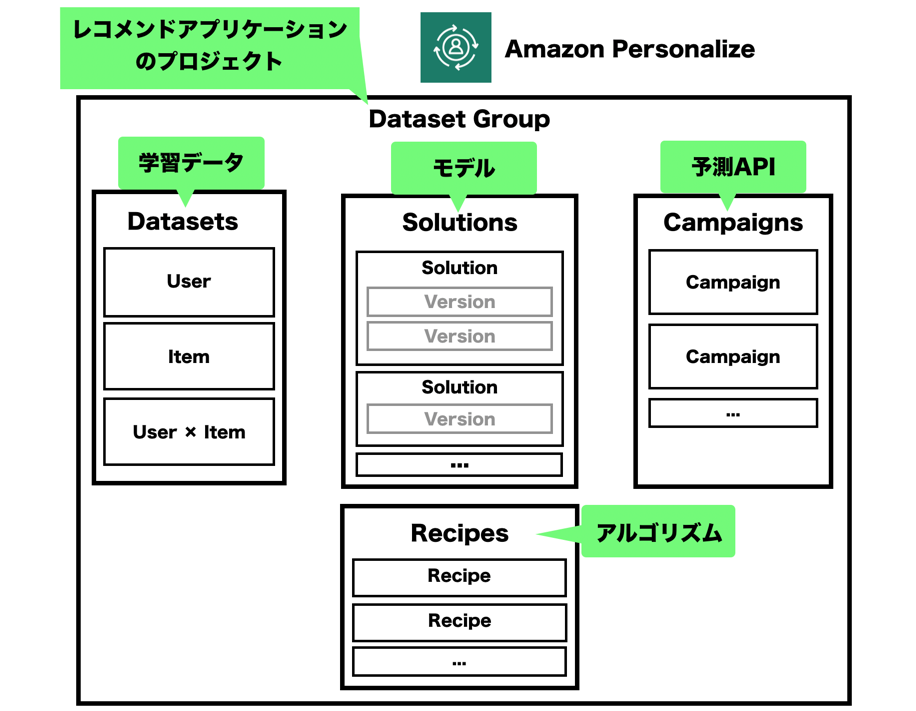

In [24]:
dir(personalize)

['_PY_TO_OP_NAME',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_client_config',
 '_convert_to_request_dict',
 '_emit_api_params',
 '_endpoint',
 '_exceptions',
 '_exceptions_factory',
 '_get_waiter_config',
 '_load_exceptions',
 '_loader',
 '_make_api_call',
 '_make_request',
 '_register_handlers',
 '_request_signer',
 '_response_parser',
 '_serializer',
 '_service_model',
 'can_paginate',
 'create_batch_inference_job',
 'create_batch_segment_job',
 'create_campaign',
 'create_dataset',
 'create_dataset_export_job',
 'create_dataset_group',
 'create_dataset_import_job',
 'create_event_tracker',
 'create_filter',
 'create_recommender',
 '

In [1]:
from ipywidgets import interact,Dropdown,Button,Output
from pprint import pprint
import re

In [6]:
def ARN_konmari(personalize, command='solution'):
    """
    command : 'solution', 'dataset', 'datasetGroup', 'schema', 'solutionVersion'
    """
    snake = re.sub("([A-Z])",lambda x:"_" + x.group(1).lower(), command)
    
    button = Button(description="Delete Me!")
    output = Output()
    
    dd = Dropdown(
        options=[(i[command + 'Arn']) for i in eval('personalize.list_' + snake + 's')()[command + 's']],
        description='Select {}:'.format(command))
    @interact(dd=dd)
    def f(dd):    
        pprint(eval('personalize.describe_' + snake +'(' + command + 'Arn=dd)')[command])

    display(button, output)
    def on_button_clicked(b):
        with output:
            print('deleting...{}'.format(dd.value))
            eval('personalize.delete_' + snake +'(' + command + 'Arn=dd.value)')

    button.on_click(on_button_clicked)



In [8]:
ARN_konmari(personalize, 'solutionVersion')

interactive(children=(Dropdown(description='Select solutionVersion:', options=('arn:aws:personalize:ap-northea…

Button(description='Delete Me!', style=ButtonStyle())

Output()

In [7]:
ARN_konmari(personalize, 'datasetGroup')

interactive(children=(Dropdown(description='Select datasetGroup:', options=('arn:aws:personalize:ap-northeast-…

Button(description='Delete Me!', style=ButtonStyle())

Output()

In [34]:
ARN_konmari(personalize, 'schema')

interactive(children=(Dropdown(description='Select schema:', options=('arn:aws:personalize:ap-northeast-1:3591…

Button(description='Delete Me!', style=ButtonStyle())

Output()

In [28]:
ARN_konmari(personalize, 'dataset')

interactive(children=(Dropdown(description='Select dataset:', options=('arn:aws:personalize:ap-northeast-1:359…

Button(description='Delete Me!', style=ButtonStyle())

Output()

In [29]:
ARN_konmari(personalize, 'solution')

interactive(children=(Dropdown(description='Select solution:', options=('arn:aws:personalize:ap-northeast-1:35…

Button(description='Delete Me!', style=ButtonStyle())

Output()

## back to tutorial

In [30]:
create_dataset_group_response = personalize.create_dataset_group(
    name = "amazon-pantry-aws-similar-items-ngym"
)

dataset_group = create_dataset_group_response['datasetGroupArn']
print(json.dumps(create_dataset_group_response, indent=2))

{
  "datasetGroupArn": "arn:aws:personalize:ap-northeast-1:359123155553:dataset-group/amazon-pantry-aws-similar-items-ngym",
  "ResponseMetadata": {
    "RequestId": "db054fed-222a-4114-9d73-62689f2966a5",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sat, 16 Apr 2022 14:29:27 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "120",
      "connection": "keep-alive",
      "x-amzn-requestid": "db054fed-222a-4114-9d73-62689f2966a5"
    },
    "RetryAttempts": 0
  }
}


Since dataset groups can take a few seconds to be fully created, let's wait until they both have a status of ACTIVE.

In [31]:
in_progress_dataset_group_arns = [ dataset_group ]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for dataset_group_arn in in_progress_dataset_group_arns:
        describe_dataset_group_response = personalize.describe_dataset_group(
            datasetGroupArn = dataset_group_arn
        )
        status = describe_dataset_group_response["datasetGroup"]["status"]
        if status == "ACTIVE":
            print("Dataset group create succeeded for {}".format(dataset_group_arn))
            in_progress_dataset_group_arns.remove(dataset_group_arn)
        elif status == "CREATE FAILED":
            print("Create failed for {}".format(dataset_group_arn))
            in_progress_dataset_group_arns.remove(dataset_group_arn)

    if len(in_progress_dataset_group_arns) <= 0:
        break
    else:
        print("At least one dataset group create is still in progress")
                
    time.sleep(10)

Dataset group create succeeded for arn:aws:personalize:ap-northeast-1:359123155553:dataset-group/amazon-pantry-aws-similar-items-ngym


### Create Interactions dataset schema and datasets

We will be creating a single schema for the interactions dataset type and sharing it across both solution versions. This is possible since schemas are global to your AWS account and not specific to a dataset group.

In [35]:
interactions_schema = schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        },
        {
            "name": "EVENT_VALUE",
            "type": "float"
        },
        {
            "name": "EVENT_TYPE",
            "type": "string"
        }
    ],
    "version": "1.0"
}
            
create_schema_response = personalize.create_schema(
    name = "amazon-pantry-interactions-1-ngym",
    schema = json.dumps(interactions_schema)
)

interaction_schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:ap-northeast-1:359123155553:schema/amazon-pantry-interactions-1-ngym",
  "ResponseMetadata": {
    "RequestId": "31609b8d-ff5d-44ab-b042-ab3764646b7b",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sat, 16 Apr 2022 14:35:05 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "104",
      "connection": "keep-alive",
      "x-amzn-requestid": "31609b8d-ff5d-44ab-b042-ab3764646b7b"
    },
    "RetryAttempts": 0
  }
}


Next we'll create an Interactions dataset in our dataset group specifying the schema we just created.

In [36]:
dataset_type = "INTERACTIONS"
create_dataset_response = personalize.create_dataset(
    name = "amazon-pantry-ints-ngym",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group,
    schemaArn = interaction_schema_arn
)

interactions_dataset = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:ap-northeast-1:359123155553:dataset/amazon-pantry-aws-similar-items-ngym/INTERACTIONS",
  "ResponseMetadata": {
    "RequestId": "55357a47-8598-4879-bbe7-3913c214e256",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sat, 16 Apr 2022 14:36:52 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "122",
      "connection": "keep-alive",
      "x-amzn-requestid": "55357a47-8598-4879-bbe7-3913c214e256"
    },
    "RetryAttempts": 0
  }
}


### Stage Interactions CSV in S3

Before we can upload the interactions CSV we created earlier into the Personalize datasets that we just created, we need to stage the CSV in an S3 bucket.

Let's create an S3 bucket and copy the interactions CSV file to the bucket.

In [37]:
# Determine the current S3 region where this notebook is being hosted in SageMaker.
with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]
print(region)

ap-northeast-1


In [38]:

s3 = boto3.client('s3')
account_id = boto3.client('sts').get_caller_identity().get('Account')
bucket_name = "amazon-pantry-personalize-example-ngym"+account_id
print(bucket_name)
if region == "us-east-1":
    s3.create_bucket(Bucket=bucket_name)
else:
    region='ap-northeast-1'
    s3.create_bucket(
        Bucket=bucket_name,
        CreateBucketConfiguration={'LocationConstraint': region}
    )

amazon-pantry-personalize-example-ngym359123155553


#### Upload Interactions CSV to S3

In [39]:
boto3.Session().resource('s3').Bucket(bucket_name).Object(interactions_filename).upload_file(interactions_filename)

### Create S3 bucket policy and IAM role

Before we can submit a dataset import job to Personalize, we have to create a bucket policy and IAM role that will give Personalize access to our bucket.

In [40]:
policy = {
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {
                "Service": "personalize.amazonaws.com"
            },
            "Action": [
                "s3:*Object",
                "s3:ListBucket"
            ],
            "Resource": [
                "arn:aws:s3:::{}".format(bucket_name),
                "arn:aws:s3:::{}/*".format(bucket_name)
            ]
        }
    ]
}

s3.put_bucket_policy(Bucket=bucket_name, Policy=json.dumps(policy))

{'ResponseMetadata': {'RequestId': 'FEB804JXQNZ0E1J5',
  'HostId': 'uO084Fpc5523A5+zAl0gwa4HgvmytpoTARN94FIn3sKTFqe8jj9JNbPKQjTUNvEQW1jILMMig2s=',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'x-amz-id-2': 'uO084Fpc5523A5+zAl0gwa4HgvmytpoTARN94FIn3sKTFqe8jj9JNbPKQjTUNvEQW1jILMMig2s=',
   'x-amz-request-id': 'FEB804JXQNZ0E1J5',
   'date': 'Sat, 16 Apr 2022 14:39:18 GMT',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}

In [41]:
iam = boto3.client("iam")

role_name = "PersonalizeRoleAmazonPantryAwsSimilarItems-ngym"
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "personalize.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

create_role_response = iam.create_role(
    RoleName = role_name,
    AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
)

# AmazonPersonalizeFullAccess provides access to any S3 bucket with a name that includes "personalize" or "Personalize" 
# if you would like to use a bucket with a different name, please consider creating and attaching a new policy
# that provides read access to your bucket or attaching the AmazonS3ReadOnlyAccess policy to the role
policy_arn = "arn:aws:iam::aws:policy/service-role/AmazonPersonalizeFullAccess"
iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = policy_arn
)

# Now add S3 support
iam.attach_role_policy(
    PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess',
    RoleName=role_name
)
time.sleep(20) # wait for a minute to allow IAM role policy attachment to propagate

role_arn = create_role_response["Role"]["Arn"]
print(role_arn)

arn:aws:iam::359123155553:role/PersonalizeRoleAmazonPantryAwsSimilarItems-ngym


### Import Interactions datasets

Now we're ready to import the staged Interactions CSV in our S3 bucket to the Personalize dataset we created.

In [44]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "amazon-pantry-interactions-import-ngym",
    datasetArn = interactions_dataset,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket_name, interactions_filename)
    },
    roleArn = role_arn
)

dataset_import_job = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:ap-northeast-1:359123155553:dataset-import-job/amazon-pantry-interactions-import-ngym",
  "ResponseMetadata": {
    "RequestId": "b528f8f3-7f7e-4cfb-825b-4d58ab647fb0",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sat, 16 Apr 2022 14:51:44 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "131",
      "connection": "keep-alive",
      "x-amzn-requestid": "b528f8f3-7f7e-4cfb-825b-4d58ab647fb0"
    },
    "RetryAttempts": 0
  }
}


### Create Items dataset schema and datasets

Next we will repeat the process for the items datasets.

Create a schema that includes the description. Be sure to take note of the `"textual": True` attribute on the `DESCRIPTION` field. This is how you differentiate unstructured text fields from categorical and string fields. Without this attribute, Personalize will not apply natural language processing techniques to extract features from this text.

In [45]:
item_schema = {
    "type": "record",
    "name": "Items",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "BRAND",
            "type": [ "null", "string" ],
            "categorical": True
        },{
            "name": "PRICE",
            "type": [ "null", "float" ],
        },{
            "name": "DESCRIPTION",
            "type": [ "null", "string" ],
            "textual": True
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "amazon-pantry-items-schema-ngym",
    schema = json.dumps(item_schema)
)

item_schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:ap-northeast-1:359123155553:schema/amazon-pantry-items-schema-ngym",
  "ResponseMetadata": {
    "RequestId": "b7030a6f-e3bb-41b1-9594-e20b2906f797",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sat, 16 Apr 2022 14:53:28 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "102",
      "connection": "keep-alive",
      "x-amzn-requestid": "b7030a6f-e3bb-41b1-9594-e20b2906f797"
    },
    "RetryAttempts": 0
  }
}


Next we will create Personalize datasets in our dataset group, taking special care to specify the approprate schema ARN for each dataset.

In [46]:
dataset_type = "ITEMS"
create_dataset_response = personalize.create_dataset(
    name = "amazon-pantry-items-ngym",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = item_schema_arn
)

items_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:ap-northeast-1:359123155553:dataset/amazon-pantry-aws-similar-items-ngym/ITEMS",
  "ResponseMetadata": {
    "RequestId": "e736031d-d9ce-47f0-9e9e-fc076269fc2c",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sat, 16 Apr 2022 14:53:44 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "115",
      "connection": "keep-alive",
      "x-amzn-requestid": "e736031d-d9ce-47f0-9e9e-fc076269fc2c"
    },
    "RetryAttempts": 0
  }
}


#### Stage Items CSV in S3

Next we'll copy our two items CSV files to the same S3 bucket create above.

In [47]:
boto3.Session().resource('s3').Bucket(bucket_name).Object(items_filename).upload_file(items_filename)

### Import Items datasets for each dataset group

Since the S3 bucket policy and IAM role are already setup, we can just submit two dataset import jobs to import the Items CSVs.

In [48]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "amazon-pantry-items-import-job-ngym",
    datasetArn = items_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket_name, items_filename)
    },
    roleArn = role_arn
)

dataset_import_job_items_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:ap-northeast-1:359123155553:dataset-import-job/amazon-pantry-items-import-job-ngym",
  "ResponseMetadata": {
    "RequestId": "1ff3e335-d042-4a3e-a045-ba872484c473",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sat, 16 Apr 2022 14:54:13 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "128",
      "connection": "keep-alive",
      "x-amzn-requestid": "1ff3e335-d042-4a3e-a045-ba872484c473"
    },
    "RetryAttempts": 0
  }
}


### Wait for Interactions dataset import jobs to complete

The following cell will wait for both import jobs to complete.

In [49]:
%%time

in_progress_import_arns = [ dataset_import_job ]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for import_arn in in_progress_import_arns:
        describe_dataset_import_job_response = personalize.describe_dataset_import_job(
            datasetImportJobArn = import_arn
        )
        status = describe_dataset_import_job_response["datasetImportJob"]['status']
        if status == "ACTIVE":
            print("Dataset import succeeded for {}".format(import_arn))
            in_progress_import_arns.remove(import_arn)
        elif status == "CREATE FAILED":
            print("Create failed for {}".format(import_arn))
            in_progress_import_arns.remove(import_arn)

    if len(in_progress_import_arns) <= 0:
        break
    else:
        print("At least one dataset import job is still in progress")
                
    time.sleep(60)

At least one dataset import job is still in progress
At least one dataset import job is still in progress
Dataset import succeeded for arn:aws:personalize:ap-northeast-1:359123155553:dataset-import-job/amazon-pantry-interactions-import-ngym
CPU times: user 34.9 ms, sys: 0 ns, total: 34.9 ms
Wall time: 2min


### Wait for Items import job to complete

The following logic will wait until both items datasets are fully imported into each dataset group.

In [51]:
%%time

in_progress_import_arns = [ dataset_import_job_items_arn ]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for import_arn in in_progress_import_arns:
        describe_dataset_import_job_response = personalize.describe_dataset_import_job(
            datasetImportJobArn = import_arn
        )
        status = describe_dataset_import_job_response["datasetImportJob"]['status']
        if status == "ACTIVE":
            print("Dataset import succeeded for {}".format(import_arn))
            in_progress_import_arns.remove(import_arn)
        elif status == "CREATE FAILED":
            print("Create failed for {}".format(import_arn))
            in_progress_import_arns.remove(import_arn)

    if len(in_progress_import_arns) <= 0:
        break
    else:
        print("At least one dataset import job is still in progress")
                
    time.sleep(60)

Dataset import succeeded for arn:aws:personalize:ap-northeast-1:359123155553:dataset-import-job/amazon-pantry-items-import-job-ngym
CPU times: user 12.6 ms, sys: 3.86 ms, total: 16.5 ms
Wall time: 63.3 ms


## Create solutions and solution versions

With the interactions and items datasets imported into each dataset group, we will next create solutions and solution versions using the user-personalization recipe for the data in each dataset group.

First, let's list the Personalize recipes available.

In [52]:
personalize.list_recipes()

{'recipes': [{'name': 'aws-ecomm-customers-who-viewed-x-also-viewed',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-ecomm-customers-who-viewed-x-also-viewed',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2022, 4, 7, 18, 49, 24, 7000, tzinfo=tzlocal()),
   'domain': 'ECOMMERCE'},
  {'name': 'aws-ecomm-frequently-bought-together',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-ecomm-frequently-bought-together',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2022, 4, 7, 18, 49, 24, 7000, tzinfo=tzlocal()),
   'domain': 'ECOMMERCE'},
  {'name': 'aws-ecomm-popular-items-by-purchases',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-ecomm-popular-items-by-purchases',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0, tzinfo=tzlocal()),
   'lastUpdatedDate

We will use the `aws-sims` and `aws-similar-items` recipes to train two solutions in this notebook.

In [53]:
sims_recipe_arn = "arn:aws:personalize:::recipe/aws-sims"
similar_items_recipe_arn = "arn:aws:personalize:::recipe/aws-similar-items"

First, we will create a solution and solution version for each of the recipes.

In [54]:
sims_create_solution_response = personalize.create_solution(
    name = "amazon-pantry-sims-solution-example-ngym",
    datasetGroupArn = dataset_group_arn,
    recipeArn = sims_recipe_arn
)

sims_solution_arn = sims_create_solution_response['solutionArn']

In [55]:
print(sims_solution_arn)

arn:aws:personalize:ap-northeast-1:359123155553:solution/amazon-pantry-sims-solution-example-ngym


In [56]:
sims_solution_version_response = personalize.create_solution_version(
    solutionArn = sims_solution_arn
)

In [57]:
sims_solution_version_arn = sims_solution_version_response['solutionVersionArn']
print(json.dumps(sims_solution_version_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:ap-northeast-1:359123155553:solution/amazon-pantry-sims-solution-example-ngym/6ac1584a",
  "ResponseMetadata": {
    "RequestId": "2fb2b265-fd8b-4cf0-8288-064a664be470",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sat, 16 Apr 2022 15:08:15 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "131",
      "connection": "keep-alive",
      "x-amzn-requestid": "2fb2b265-fd8b-4cf0-8288-064a664be470"
    },
    "RetryAttempts": 0
  }
}


Next we will create a solution and solution version in the dataset group that includes the item descriptions.

In [58]:
similar_items_create_solution_response = personalize.create_solution(
    name = "amazon-pantry-aws-similar-items-solution-example-ngym",
    datasetGroupArn = dataset_group_arn,
    recipeArn = similar_items_recipe_arn
)

similar_items_solution_arn = similar_items_create_solution_response['solutionArn']

In [59]:
similar_items_solution_version_response = personalize.create_solution_version(
    solutionArn = similar_items_solution_arn
)

In [60]:
similar_items_solution_version_arn = similar_items_solution_version_response['solutionVersionArn']
print(json.dumps(similar_items_solution_version_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:ap-northeast-1:359123155553:solution/amazon-pantry-aws-similar-items-solution-example-ngym/94dd5073",
  "ResponseMetadata": {
    "RequestId": "6b8e5b06-a290-48c3-9c7f-65cae6ea9be8",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sat, 16 Apr 2022 15:08:34 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "144",
      "connection": "keep-alive",
      "x-amzn-requestid": "6b8e5b06-a290-48c3-9c7f-65cae6ea9be8"
    },
    "RetryAttempts": 0
  }
}


### Wait for solution versions to become active

Finally, we'll wait for the solution versions to finish being created. This step is where Personalize trains machine learning models based on the datasets and selected recipe. Personalize will also split the interactions datasets into training and evaluation portions so it can evaluate the quality of recommendations against the trained model using held out data.

You will notice that the solution version in the dataset group that includes the description data will take longer to train than the one without the description.

In [61]:
%%time

in_progress_solution_versions = [
    sims_solution_version_arn,
    similar_items_solution_version_arn
]

max_time = time.time() + 10*60*60 # 10 hours
while time.time() < max_time:
    for solution_version_arn in in_progress_solution_versions:
        version_response = personalize.describe_solution_version(
            solutionVersionArn = solution_version_arn
        )
        status = version_response["solutionVersion"]["status"]
        
        if status == "ACTIVE":
            print("Build succeeded for {}".format(solution_version_arn))
            in_progress_solution_versions.remove(solution_version_arn)
        elif status == "CREATE FAILED":
            print("Build failed for {}".format(solution_version_arn))
            in_progress_solution_versions.remove(solution_version_arn)
    
    if len(in_progress_solution_versions) <= 0:
        break
    else:
        print("At least one solution build is still in progress")
        
    time.sleep(60)

At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
Build succeeded for 

Generally speaking, the addition of text-based unstructured meta will increase training time. In our case, you can see above that the solution version that trained on the dataset with product descriptions took about 15 minutes longer than the solution version trained on the dataset without production descriptions. This difference will vary based on the composition and text values for your datasets.

Let's inspect the training hours for each solution version and compare them as well.

In [11]:
ARN_konmari(personalize, 'solutionVersion')

interactive(children=(Dropdown(description='Select solutionVersion:', options=('arn:aws:personalize:ap-northea…

Button(description='Delete Me!', style=ButtonStyle())

Output()

In [15]:
sims_solution_version_arn= 'arn:aws:personalize:ap-northeast-1:359123155553:solution/amazon-pantry-sims-solution-example-ngym/6ac1584a'

In [16]:
similar_items_solution_version_arn= 'arn:aws:personalize:ap-northeast-1:359123155553:solution/amazon-pantry-aws-similar-items-solution-example-ngym/94dd5073'


In [17]:
response = personalize.describe_solution_version(solutionVersionArn = sims_solution_version_arn)
training_hours_sims = response['solutionVersion']['trainingHours']

response = personalize.describe_solution_version(solutionVersionArn = similar_items_solution_version_arn)
training_hours_similar_items = response['solutionVersion']['trainingHours']
training_diff = (training_hours_sims - training_hours_similar_items) / training_hours_similar_items

print(f"Training hours sims: {training_hours_sims}")
print(f"Training hours similar items: {training_hours_similar_items}")

print("Difference of {:.2%}".format(training_diff))

Training hours sims: 1.761
Training hours similar items: 3.566
Difference of -50.62%


The training hours used for cost calculations was about 50% higher for training with the description column. 

The wall/clock time and training hours will vary depending on the size of your datasets but this information can help you assess the trade off when considering adding unstructured text to your datasets.

In [63]:
sims_solution = {
        "solution_arn": sims_solution_arn,
        "solution_version_arn": sims_solution_version_arn
}
sims_v2_solution = {
        "solution_arn": similar_items_solution_arn,
        "solution_version_arn": similar_items_solution_version_arn
}

In [64]:
def create_campaign(solution,name):
    create_campaign_response = personalize.create_campaign(
        name = "personalize-demo-" + name + "example",
        solutionVersionArn = solution['solution_version_arn'],
        minProvisionedTPS = 1
    )

    campaign_arn = create_campaign_response['campaignArn']
    print('campaign_arn:' + campaign_arn)
    return campaign_arn

def waitForCampaign(solution):
    max_time = time.time() + 3*60*60 # 3 hours
    while time.time() < max_time:
        describe_campaign_response = personalize.describe_campaign(
            campaignArn = solution['campaign_arn']
        )
        status = describe_campaign_response["campaign"]["status"]
        print("Campaign: {} {}".format(solution['campaign_arn'], status))

        if status == "ACTIVE" or status == "CREATE FAILED":
            break

        time.sleep(60)

#### Create and wait for the 2 Campaigns
Create a campaign for each of the items similarities recipes, but keep all the other settings the same to demonstrate the impact of the addition of metadata.

In [65]:
sims_solution['campaign_arn'] = create_campaign(sims_solution, 'sims')
sims_v2_solution['campaign_arn'] = create_campaign(sims_v2_solution, 'aws-similar-items')

campaign_arn:arn:aws:personalize:ap-northeast-1:359123155553:campaign/personalize-demo-simsexample
campaign_arn:arn:aws:personalize:ap-northeast-1:359123155553:campaign/personalize-demo-aws-similar-itemsexample


In [66]:
waitForCampaign(sims_solution)
waitForCampaign(sims_v2_solution)

Campaign: arn:aws:personalize:ap-northeast-1:359123155553:campaign/personalize-demo-simsexample CREATE PENDING
Campaign: arn:aws:personalize:ap-northeast-1:359123155553:campaign/personalize-demo-simsexample CREATE IN_PROGRESS
Campaign: arn:aws:personalize:ap-northeast-1:359123155553:campaign/personalize-demo-simsexample CREATE IN_PROGRESS
Campaign: arn:aws:personalize:ap-northeast-1:359123155553:campaign/personalize-demo-simsexample CREATE IN_PROGRESS
Campaign: arn:aws:personalize:ap-northeast-1:359123155553:campaign/personalize-demo-simsexample CREATE IN_PROGRESS
Campaign: arn:aws:personalize:ap-northeast-1:359123155553:campaign/personalize-demo-simsexample CREATE IN_PROGRESS
Campaign: arn:aws:personalize:ap-northeast-1:359123155553:campaign/personalize-demo-simsexample CREATE IN_PROGRESS
Campaign: arn:aws:personalize:ap-northeast-1:359123155553:campaign/personalize-demo-simsexample CREATE IN_PROGRESS
Campaign: arn:aws:personalize:ap-northeast-1:359123155553:campaign/personalize-demo-

# Getting Recommendations

First we are going to select three types of items to infer with
1. Item with a high number of interactions
1. Item with a low number of interactions
1. Random itemId

We will then look at how each of the models behave with each of the provided items


In [69]:
items_interacted_df

,USER_ID,ITEM_ID,TIMESTAMP,EVENT_VALUE,EVENT_TYPE
0,A1NKJW0TNRVS7O,B0000DIWNZ,1418515200,5,reviewed
1,A2L6X37E8TFTCC,B0000DIWNZ,1416441600,4,reviewed
2,A2WPR4W6V48121,B0000DIWNZ,1412985600,4,reviewed
4,A1OWT4YZGB5GV9,B0000DIWNZ,1407628800,4,reviewed
5,A1GN2ADKF1IE7K,B0000DIWNZ,1405296000,5,reviewed
...,...,...,...,...,...
471609,A19GSVHXVT5NNF,B01HI8JVI8,1494892800,5,reviewed
471610,ABSCTKLX9F9IU,B01HI8JVI8,1493769600,5,reviewed
471611,A2R33RCWKDHZ3L,B01HI8JVI8,1492646400,5,reviewed
471612,A2INGHYEXZDHMC,B01HI8JVI8,1492560000,5,reviewed


Lets take a look at our interactions dataset and plot the distribution of items that have been interacted with

In [68]:
items_interacted_df = positive_reviews_df.copy()
# Getting unique aisns counts
asin_interaction_count = items_interacted_df['ITEM_ID'].value_counts()
# Transforming panda series to df
asin_interaction_count_df = pd.DataFrame({'asin':asin_interaction_count.index, 'count':asin_interaction_count.values})
asin_interaction_count_df

,asin,count
0,B00XA9DADC,5288
1,B00I3MVY9I,5086
2,B00W6T13OU,4023
3,B0014CZUZ8,3225
4,B0014CSIG6,2600
...,...,...
10579,B010D06ZNW,1
10580,B0111KA1MY,1
10581,B00CQEIJXI,1
10582,B0029JZ1TA,1


In [59]:
asin_interaction_count_df.describe(include='int')

,count
count,10584.000000
mean,36.630008
std,123.480233
min,1.000000
25%,4.000000
50%,12.000000
75%,33.250000
max,5288.000000


As we can see above, the highest interacted item has ~5k interactions, lets plot the distribution of all items. Here we can see that there are items with high number of interactions and some with very low to non interactions.

<AxesSubplot:>

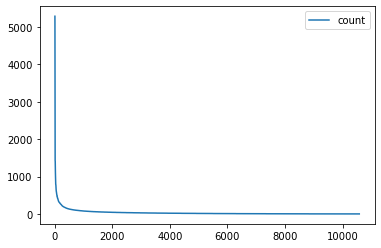

In [60]:
asin_interaction_count_df.plot()

Below we can see a closer look at items with 100 to 300 interactions. These are going to give us the most variable results when testing.

<AxesSubplot:>

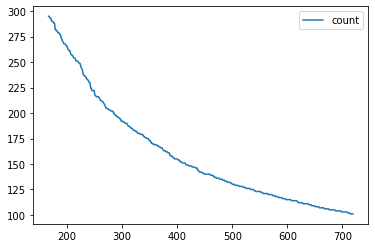

In [61]:
zoom_interactions = asin_interaction_count_df.copy()
zoom_interactions = zoom_interactions.loc[(zoom_interactions["count"] > 100) & (zoom_interactions["count"] < 300)]
zoom_interactions.plot()

Now lets define some functions to explore the items metadata

In [70]:
# https://www.geeksforgeeks.org/how-to-select-rows-from-a-dataframe-based-on-column-values/
def get_item_brand(item_id):
    """
    Takes in an ID, returns its brand
    """

    return items_df.query('ITEM_ID=="{}"'.format(item_id))['BRAND'].item()

def get_item_price(item_id):
    """
    Takes in an ID, returns its brand
    """

    return items_df.query('ITEM_ID=="{}"'.format(item_id))['PRICE'].item()

def get_item_description(item_id):
    """
    Takes in an ID, returns its brand
    """

    return items_df.query('ITEM_ID=="{}"'.format(item_id))['DESCRIPTION'].item()
def get_item_df(item_id):
    """
    Takes in an ID, returns a title
    """
    temp_df = items_df.query('ITEM_ID=="{}"'.format(item_id))
  
    temp_df['INTERACTIONS_COUNT'] = get_item_count(item_id)
    return temp_df
def get_item_count(item_id):
    return asin_interaction_count_df.query('asin=="{}"'.format(item_id))['count'].item()
    
def get_recs_df(item_id, campaign):
    response = personalize_runtime.get_recommendations(
        campaignArn=campaign,
        itemId=item_id,
        numResults=10
    )
    return clean_recs_list(response['itemList'])

def clean_recs_list(rec_list):
    items = []
    for each in rec_list:
        items.append([each['itemId'], get_item_brand(each['itemId']), get_item_price(each['itemId']), get_item_description(each['itemId']), get_item_count(each['itemId'])])
    return pd.DataFrame (items, columns = ['ITEM_ID', 'BRAND', 'PRICE','DESCRIPTION', 'INTERACTIONS_COUNT'])

Lets get a random item id and explore each model recommendations

In [63]:
asin_interaction_count_df.sample()['asin'].item()

'B012X39R5K'

In [71]:
asin = asin_interaction_count_df.sample(1)['asin'].item()
recommended_item_df = get_item_df(asin)
recommendations_sims_df = get_recs_df(asin,sims_solution['campaign_arn'])
recommendations_sims_v2_df = get_recs_df(asin,sims_v2_solution['campaign_arn'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


This is the item we are going to run inference against, as we can see here we have the brand, price, and number of interactions. The theory is that for items with low interactions SIMS will return mostly popular items, and the new aws-item-similarity recipe will return items more related to the current item metadata

In [72]:
recommended_item_df

,ITEM_ID,BRAND,PRICE,DESCRIPTION,INTERACTIONS_COUNT
3563,B00V1P4O1Y,Quaker,2.99,Enjoy a bowl of Quaker High Fiber Cinnamon Swi...,33


In [73]:
recommended_item_df['DESCRIPTION'].item()

"Enjoy a bowl of Quaker High Fiber Cinnamon Swirl Instant Oatmeal for energy and nutrition you want for the morning ahead. You can meet 40% of your daily fiber needs (based on a 2,000-calorie diet) with just one serving. A serving of High Fiber Cinnamon Swirl Oatmeal also contains calcium, iron, and five other vitamins and minerals. Quaker oats are made from 100% whole grain oats, with a Cinnamon Swirl flavor for a sweet taste. Getting a bowl of High Fiber Cinnamon Swirl Oatmeal ready is simple enough to do on even the busiest morning. Just put the oatmeal packet contents in a bowl, measure and add boiling water, and stir. Your oatmeal is ready to eat 90 seconds later. And your wholesome breakfast option isn't limited to home. Single-serving packets let you make a hearty and tasty meal anywhere there's hot water. For more than 135 years, Quaker's brands have served as symbols of quality, great taste and nutrition. Holding leadership positions in their respective categories, Quaker Oats

In [74]:
recommendations_sims_df

,ITEM_ID,BRAND,PRICE,DESCRIPTION,INTERACTIONS_COUNT
0,B00XA9DADC,Twinings,8.00,Made with 100% pure peppermint leaves. An upli...,5288
1,B00I3MVY9I,Crest,NaN,Unleash A Brilliantly Dimensional Smile A 3D W...,5086
2,B00W6T13OU,Brooklyn Beans,NaN,"In Brooklyn, we know a thing or two about bein...",4023
3,B00HZ6X8QU,Tide,11.99,Tide Original liquid laundry detergent provide...,1791
4,B0014CZUZ8,Planters,5.98,Nuts are the heroes of wholesome snacking. And...,3225
5,B00I9KR31C,Viva,NaN,View larger Product Description Dinner is over...,1467
6,B00W6T208I,Celestial Seasonings,NaN,A full-bodied black tea made from ingredients ...,1415
7,B00I8YJZ4M,Tom's of Maine,3.79,Toms of Maine Goodness Day Mt. Agamenticus loc...,1403
8,B00ICZZCEE,Pure Protein,7.09,"Pure Protein 23 Grams, Vanilla Creme(4 Count, ...",1429
9,B0014CSIG6,Mauna Loa,NaN,2g Net carbs. Taste of the tropics. Share this...,2600


Cost category and product groupings

In [75]:
recommendations_sims_v2_df

,ITEM_ID,BRAND,PRICE,DESCRIPTION,INTERACTIONS_COUNT
0,B015TYDZTE,Bounty,11.42,Ever try one of those bargain' paper towels an...,606
1,B000SSS6AU,Scotch-Brite,2.56,Keep your cookware performing at its best with...,338
2,B011DX5G92,Charmin,6.99,Charmin Ultra Strong toilet paper cleans bette...,536
3,B00NAZ5TW6,Kleenex,2.99,Hands are only as clean as the towels used to ...,73
4,B00NP79AI8,Nestle Pure Life,2.23,Nestle Pure Life Purified Water (.5-liter / 12...,678
5,B00R1H0SCA,Nature Valley,2.98,Made with 100% Natural Whole Grain Oats; 16g o...,66
6,B01BK9MXZE,Nature Valley,2.95,Each biscuit has a delicious crisp texture and...,282
7,B015O6PSO2,Frito Lay,10.67,With pre-portioned bags of your favorite snack...,394
8,B013OY25GA,Snack Pack,2.78,Give your kids a delicious treat with the Snac...,249
9,B0014CZUZ8,Planters,5.98,Nuts are the heroes of wholesome snacking. And...,3225


Let's print the descriptions too see if they match our item theme

In [76]:
for index, row in recommendations_sims_v2_df.iterrows():
    print('----ITEM----')
    print('Recommendation number {index}, BRAND: {brand}, PRICE: {price}'.format(index=index+1, brand=row['BRAND'], price=row['PRICE']))
    print('----DESCRIPTION----')
    print(row['DESCRIPTION'])


----ITEM----
Recommendation number 1, BRAND: Bounty, PRICE: 11.42
----DESCRIPTION----
Ever try one of those bargain' paper towels and go through so many sheets that the roll just disappears? With Bounty, the roll doesnt disappear. Bounty paper towels are 2X more absorbent,* so the roll can last up to 50% longer,* Bounty quickly absorbs messes, so you can clean up and move on without wasting time or towels. Plus, it comes in a variety of sizes and prints, including Bounty Select-A-Size, so you can choose the Bounty paper towel that's best for you and your family. Choose the paper towel you can count on: Bounty, the longer-lasting Quicker Picker Upper.* *Vs. leading ordinary brand. Dont be let down by bargain brand paper towels that tear and disappear in days. Try Bounty instead. Bounty is 2x more absorbent,* so you can pick up messes with as little as one sheet. And that means you dont have to keep pulling on a roll of Bounty, because it can last 50% longer. You'll spend more time doing

# Targeted examples

Now let's take a look at some more targeted items to see how these two models behave

## Popular item

In [77]:
asin = 'B00HZ6X8QU'
recommended_item_df = get_item_df(asin)
recommendations_sims_df = get_recs_df(asin,sims_solution['campaign_arn'])
recommendations_sims_v2_df = get_recs_df(asin,sims_v2_solution['campaign_arn'])
recommended_item_df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ITEM_ID,BRAND,PRICE,DESCRIPTION,INTERACTIONS_COUNT
709,B00HZ6X8QU,Tide,11.99,Tide Original liquid laundry detergent provide...,1791


The theory is that for items with low interactions SIMS will return mostly popular items, and the new aws-item-similarity recipe will return items more related to the current item metadata (price and description)

**Full description:**


In [78]:
recommended_item_df['DESCRIPTION'].item()

'Tide Original liquid laundry detergent provides the Tide clean you love, now more concentrated for more stain removal and freshness and less water*. Americas #1 detergent** is specifically designed to cover your many laundry needs. Also try our small but powerful Tide PODS laundry pacs. Measure your loads with cap. For medium loads, fill to bar 1. For large loads, fill to bar 3. For HE full loads, fill to bar 5. Add clothes, pour into dispenser, start washer. * vs. previous formula ** based on sales For an amazing clean you know and love, theres only one original: Tide Original Scent High Efficiency Laundry Detergent which removes over 100 stains in one wash. Its revitalizing scent is infused with aloe and floral notes to help keep your familys clothes smelling as great as they look. The formula also allows you to enjoy Tide even more as it lasts up to 2x longer compared to leading baking soda detergent based on large loads use instructions (175 oz and smaller bottles). View larger Vi

#### SIMS

In [79]:
recommendations_sims_df

,ITEM_ID,BRAND,PRICE,DESCRIPTION,INTERACTIONS_COUNT
0,B00JGZBTCI,Downy,8.47,Downy April Fresh Liquid Fabric Conditioner so...,544
1,B00MTSGYG0,Bounce,8.24,"We admit, the outdoors smell great. But with o...",394
2,B00JGZCLIY,Downy,7.94,"No dyes, no perfumes, no worries: Downy Fabric...",278
3,B00PFPDRRI,Dawn,1.92,Dawn Non-Concentrated dishwashing liquid soap ...,182
4,B00UBJQHMU,Listerine,5.99,Protect your mouth from germs and get fresh br...,483
5,B01B4N9Y6C,Cottonelle,6.99,Cottonelle Clean Care toilet paper with Clean ...,570
6,B00I9JK8GU,Ziploc,4.75,Get more out of your everyday with Ziplocbrand...,475
7,B00UB7ASK4,Old Spice,7.47,Old Spice Men's Deodorant reduces underarm odo...,49
8,B00JGZBUPE,Downy,5.11,Downy April Fresh Dryer Sheets fight static cl...,117
9,B00IA6ILKC,Glad,8.49,Glad OdorShield Trash Bags in Fresh Clean Scen...,380


We can see here, the SIMS model returns popular items. Which is not optimal

#### SIMS V2

In [80]:
recommendations_sims_v2_df

,ITEM_ID,BRAND,PRICE,DESCRIPTION,INTERACTIONS_COUNT
0,B00JGZBTCI,Downy,8.47,Downy April Fresh Liquid Fabric Conditioner so...,544
1,B00HZYDW5E,Coca-Cola,4.68,,408
2,B00IAE6PWA,Pepperidge Farm,2.98,"About Pepperidge Farm: For us, baking is more ...",549
3,B00099XPD6,Carnation,1.19,"Carnation Evaporated Milk is fresh, nutritious...",1291
4,B00NAZ5RIC,Kleenex,5.99,Express your style in every aspect of your hom...,513
5,B00NMPN1JC,Thera Tears,12.44,Preservative Lubricant Eye Drops.,992
6,B00UB6T2I4,Colgate,2.96,Colgate Extra Clean Full Head Medium Toothbrus...,396
7,B00UBJQHMU,Listerine,5.99,Protect your mouth from germs and get fresh br...,483
8,B000SSS6AU,Scotch-Brite,2.56,Keep your cookware performing at its best with...,338
9,B00UFUYTMK,Honey Maid,3.00,"For nearly 90 years, Honey Maid has been a who...",307


We see very comparable recommendations across both models! Which is an expected behavior considering the item is one of the most popular across the interactions dataset. Now less take a look at recommendations of an item not as popular

## Unpopular item

In [81]:
# B017BGLXYC - SODA - low price - low interactions
asin = 'B01GCT22E4'
recommended_item_df = get_item_df(asin)
recommendations_sims_df = get_recs_df(asin,sims_solution['campaign_arn'])
recommendations_sims_v2_df = get_recs_df(asin,sims_v2_solution['campaign_arn'])
recommended_item_df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ITEM_ID,BRAND,PRICE,DESCRIPTION,INTERACTIONS_COUNT
10456,B01GCT22E4,Pepsi,3.07,"With its light, crisp taste, Diet Pepsi gives ...",6


The theory is that for items with low interactions SIMS will return mostly popular items, and the new aws-item-similarity recipe will return items more related to the current item metadata (price and description)

**Full description:**


In [82]:
recommended_item_df['DESCRIPTION'].item()

'With its light, crisp taste, Diet Pepsi gives you all the refreshment you need - with zero sugar, zero calories and zero carbs. Light. Crisp. Refreshing. Diet Pepsi. Nothing refreshes like a Diet Pepsi'

#### SIMS

In [83]:
recommendations_sims_df

,ITEM_ID,BRAND,PRICE,DESCRIPTION,INTERACTIONS_COUNT
0,B00XA9DADC,Twinings,8.00,Made with 100% pure peppermint leaves. An upli...,5288
1,B00I3MVY9I,Crest,NaN,Unleash A Brilliantly Dimensional Smile A 3D W...,5086
2,B00W6T13OU,Brooklyn Beans,NaN,"In Brooklyn, we know a thing or two about bein...",4023
3,B00HZ6X8QU,Tide,11.99,Tide Original liquid laundry detergent provide...,1791
4,B0014CZUZ8,Planters,5.98,Nuts are the heroes of wholesome snacking. And...,3225
5,B00I9KR31C,Viva,NaN,View larger Product Description Dinner is over...,1467
6,B00W6T208I,Celestial Seasonings,NaN,A full-bodied black tea made from ingredients ...,1415
7,B00I8YJZ4M,Tom's of Maine,3.79,Toms of Maine Goodness Day Mt. Agamenticus loc...,1403
8,B00ICZZCEE,Pure Protein,7.09,"Pure Protein 23 Grams, Vanilla Creme(4 Count, ...",1429
9,B0014CSIG6,Mauna Loa,NaN,2g Net carbs. Taste of the tropics. Share this...,2600


We can see here, the SIMS model returns popular items. Which is not optimal

#### SIMS V2

In [84]:
recommendations_sims_v2_df

,ITEM_ID,BRAND,PRICE,DESCRIPTION,INTERACTIONS_COUNT
0,B015O6PSO2,Frito Lay,10.67,With pre-portioned bags of your favorite snack...,394
1,B00R1H0AYQ,Nature Valley,4.93,Made with 100% Natural Whole Grain Oats; 16g o...,322
2,B00R1H0HKI,Nature Valley,2.95,Made with 100% Natural Oats Whole grain oats a...,168
3,B00R1H0SCA,Nature Valley,2.98,Made with 100% Natural Whole Grain Oats; 16g o...,66
4,B01E3VJ8L8,Premium,2.74,Premium Original Saltine Crackers are the clas...,92
5,B0014CZUZ8,Planters,5.98,Nuts are the heroes of wholesome snacking. And...,3225
6,B013OY25GA,Snack Pack,2.78,Give your kids a delicious treat with the Snac...,249
7,B015TYDZTE,Bounty,11.42,Ever try one of those bargain' paper towels an...,606
8,B011DX5G92,Charmin,6.99,Charmin Ultra Strong toilet paper cleans bette...,536
9,B00RGVOUIO,Ritz,2.78,A Treat for All AgesFrom meats and cheeses to ...,406


Let's print the descriptions too see if they match our item theme

In [85]:
for index, row in recommendations_sims_v2_df.iterrows():
    print('----ITEM----')
    print('Recommendation number {index}, BRAND: {brand}, PRICE: {price}'.format(index=index+1, brand=row['BRAND'], price=row['PRICE']))
    print('----DESCRIPTION----')
    print(row['DESCRIPTION'])


----ITEM----
Recommendation number 1, BRAND: Frito Lay, PRICE: 10.67
----DESCRIPTION----
With pre-portioned bags of your favorite snacks, its no wonder why Frito-Lay variety packs are a family tradition! whether youre celebrating a big win on the soccer field, taking a family road trip, or thinking about an afternoon snack, Frito-Lay variety packs have everybodys snack needs covered. When you grab a Frito-Lay variety pack, youre ready for anything. 32 count variety pack of four 1 ounce. Bags of lays classic potato chips, five 1 ounce. Bags of CHEETOS crunchy cheese flavored snacks, three 1 ounce. Bags of FRITOS chili cheese flavored corn chips, three 1 ounce. Bags of lays barbecue flavored potato chips, four ounce. Bags of FUNYUNS snacks, five 1 ounce. Bags of DORITOS nacho cheese flavored tortilla chips, four 1 ounce. Bags of FRITOS original corn chips, four 1 ounce. Bags of lays wavy ranch flavored potato chips. 32 Count Party Mix
----ITEM----
Recommendation number 2, BRAND: Nature V

## Conclusion

As we can see from the examples above, the new recipe `aws-similar-items` is able to infer on item similarities including their metadata information. This is a big improvement to unlock additional signals to your similar items deployments.